
# $Chessboard \space Camera \space Calibration \space  \& \space Undistortion $
### $(Fisheye \space Camera \space Model \space \& \space Pinhole \space Camera \space Model \space Comparaison)$
---
In this notebook, we explore the process of **camera calibration**, which is essential for removing distortion and achieving accurate measurements from images. Camera calibration allows us to determine the **intrinsic** and **extrinsic** parameters of a camera, including the focal length, optical center, and lens distortion. Calibration is typically performed using a known pattern, such as a **chessboard**, which provides precise 2D-3D correspondences that the calibration algorithm can use to estimate the camera parameters.
![Image Description](https://raw.githubusercontent.com/Nassimos07/Camera-Calibration-Camera-Undistortion-Fisheye-Camera-Pinhole-Python-OpenCV-/refs/heads/main/Images/image-20210521143540356.png)

### Camera Calibration Models

There are two common camera models used for calibration: the **Fisheye Model** and the **Pinhole Model**.

1. **Pinhole Camera Model**:
   - The **Pinhole Camera** model assumes that light passes through a single point (the "pinhole") and projects onto a 2D plane (the image plane).
   - It is the most basic camera model and assumes ideal lens behavior, neglecting any distortion caused by the lens. However, real cameras often exhibit distortion, especially wide-angle or fisheye lenses.

2. **Fisheye Camera Model**:
   - The **Fisheye Camera** model accounts for extreme lens distortions caused by wide-angle lenses. It is used to describe lenses with a very wide field of view, such as those used in fisheye cameras.
   - Fisheye lenses introduce significant distortion, especially at the edges of the image, causing straight lines to appear curved. This is why special calibration techniques are needed for fisheye lenses.

### Calibration Using a Chessboard

The chessboard pattern is commonly used for camera calibration because its square corners are easily detected, and the known geometric properties allow for accurate calibration. By capturing multiple images of the chessboard from different angles and orientations, we can estimate the camera's intrinsic and extrinsic parameters.

In this notebook, we compare the **Pinhole Camera Model** and the **Fisheye Camera Model** for calibration. We will evaluate the performance of both models using **chessboard images** and compare the accuracy of the calibration results based on the percentage of error between the two models.

---


# $Camera \space  Calibration  \space \& \space  Undistortion  \space (Pinhole \space Camera \space za Option)$

The function [cv.calibrateCamera](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d).estimates the intrinsic camera parameters and extrinsic parameters for each of the views. The coordinates of 3D object points and their corresponding 2D projections in each view must be specified. That may be achieved by using an object with known geometry and easily detectable feature points.

 Such an object is called a calibration rig or calibration pattern, and OpenCV has built-in support for a chessboard as a calibration rig (already did that in the first part using  **findChessboardCorners()**).

### $Patterns \space Recognition$

Found 10 valid images for calibration


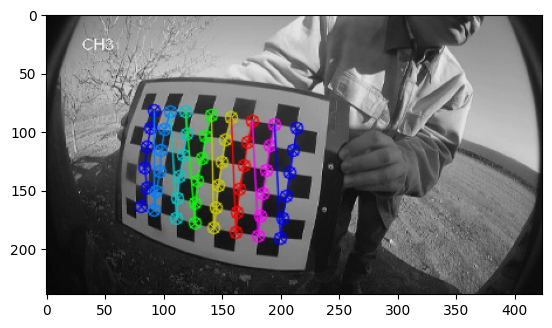

In [1]:
import numpy as np
import cv2 as cv
import glob
import matplotlib.pyplot as plt

# Define the size of the chessboard corners
corners_size = (6, 8)

# Termination criteria for corner detection
# Stop the iteration when either 30 iterations or the desired accuracy (0.001) is achieved
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 50, 0.0009)

# Prepare object points, representing the 3D points of the chessboard corners
number_corner = corners_size[0] * corners_size[1]
objp = np.zeros((number_corner, 3), np.float32)
objp[:, :2] = np.mgrid[0:corners_size[0], 0:corners_size[1]].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images
objpoints = []  # 3D point in real-world space
imgpoints = []  # 2D points in image plane

# Load images with chessboard patterns
images = glob.glob('Chessboard image for pattern recognition/*.jpg')
for fname in images:
    # Read the image and convert it to grayscale
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv.findChessboardCorners(gray, corners_size, None)
    ret, corners = cv.findChessboardCorners(
        gray,
        corners_size,
        cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_FAST_CHECK + cv.CALIB_CB_NORMALIZE_IMAGE +cv.CALIB_CB_FILTER_QUADS,
    )


    # If corners are found, refine them and add to the object and image points
    if ret:

        objpoints.append(objp)
        # Corners Detection

        corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners on the image
        cv.drawChessboardCorners(img, corners_size, corners2, ret)
        plt.imshow(img)

# Get the number of valid images for calibration
N_objects = len(objpoints)

# Print the number of valid images
print("Found " + str(N_objects) + " valid images for calibration")

### $Camera \space Calibration$

In [3]:
# Calibration process to obtain camera matrix (K) and distortion coefficients (D)
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


### $Image \space Undistortion$

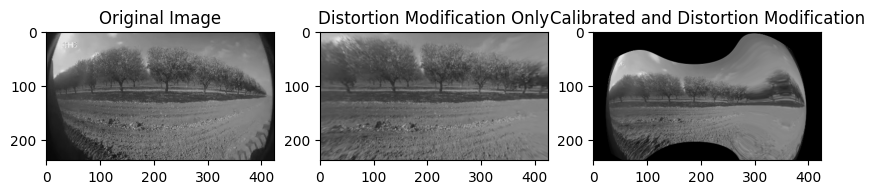

In [4]:

file_name = '2023-12-08 11-14-04.mkv100280.jpg'
img = cv.imread(file_name)

w, h = img.shape[1], img.shape[0]

newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))

# Undistort the image with camera calibration
undistorted_img_both = cv.undistort(img, mtx, dist, None, newCameraMatrix=newcameramtx)

undistorted_img_dist = cv.undistort(img, mtx, dist, None, newCameraMatrix=mtx)


# Save the undistorted images
cv.imwrite('unidistorted_only.png', undistorted_img_dist)
cv.imwrite('Calibrated_undistorted.png', undistorted_img_both)

# Display the images using matplotlib
plt.figure(figsize=(10, 8))
plt.subplot(131), plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(132), plt.imshow(cv.cvtColor(undistorted_img_dist, cv.COLOR_BGR2RGB)), plt.title('Distortion Modification Only')
plt.subplot(133), plt.imshow(cv.cvtColor(undistorted_img_both, cv.COLOR_BGR2RGB)), plt.title('Calibrated and Distortion Modification')
plt.show()


# Camera calibration (Fisheye Camera Option)




### $Patterns \space Recognition$

In [5]:
import cv2
import numpy as np
import os
import glob
CHECKERBOARD = (6,9)
subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_CHECK_COND+cv2.fisheye.CALIB_FIX_SKEW
objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
_img_shape = None
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob(r'C:\Users\MSI\Desktop\Upwork Projects\2. Computer Vision and Image Processing\6. Image processing\Zachary Upwork( Imges undistortion)\Chessboard image for pattern recognition\*.jpg')
for fname in images:
    img = cv2.imread(fname)
    if _img_shape == None:
        _img_shape = img.shape[:2]
    else:
        assert _img_shape == img.shape[:2], "All images must share the same size."
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        cv2.cornerSubPix(gray,corners,(3,3),(-1,-1),subpix_criteria)
        imgpoints.append(corners)


Found 194 valid images for calibration
DIM=(424, 239)
K=np.array([[141.6811773256289, 0.0, 213.13190704383754], [0.0, 141.39495522340758, 120.48124698641878], [0.0, 0.0, 1.0]])
D=np.array([[-0.019506848241348997], [0.00836783171866604], [-0.000540555250001176], [-0.0011784110452320391]])


### $Camera \space Calibration$

In [ ]:
N_OK = len(objpoints)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
rms, _, _, _, _ = \
    cv2.fisheye.calibrate(
        objpoints,
        imgpoints,
        gray.shape[::-1],
        K,
        D,
        rvecs,
        tvecs,
        calibration_flags,
        (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
    )
print("Found " + str(N_OK) + " valid images for calibration")
print("DIM=" + str(_img_shape[::-1]))
print("K=np.array(" + str(K.tolist()) + ")")
print("D=np.array(" + str(D.tolist()) + ")")

### $Image \space Undistortion$

In [ ]:

DIM=_img_shape[::-1]
img = cv2.imread('2023-12-08 11-14-04.mkv100580.jpg')
h,w = img.shape[:2]
map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, DIM, cv2.CV_16SC2)
fisheye_undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
cv2.imshow("undistorted", fisheye_undistorted_img)
cv2.waitKey(0)
cv2.destroyAllWindows()


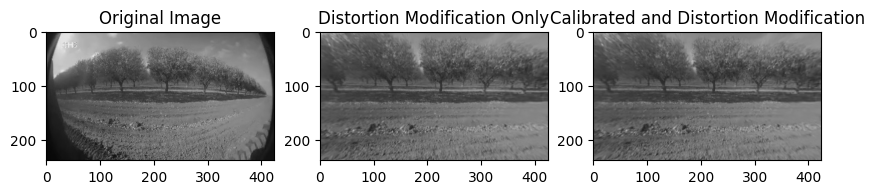

In [7]:

DIM=_img_shape[::-1]
img = cv2.imread('2023-12-08 11-14-04.mkv100280.jpg')
h,w = img.shape[:2]
map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, DIM, cv2.CV_16SC2)
fisheye_undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)







# Display the images using matplotlib
plt.figure(figsize=(10, 8))
plt.subplot(131), plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(132), plt.imshow(cv.cvtColor(fisheye_undistorted_img, cv.COLOR_BGR2RGB)), plt.title('Distortion Modification Only')
plt.subplot(133), plt.imshow(cv.cvtColor(fisheye_undistorted_img, cv.COLOR_BGR2RGB)), plt.title('Calibrated and Distortion Modification')
plt.show()


# $Comparaison$

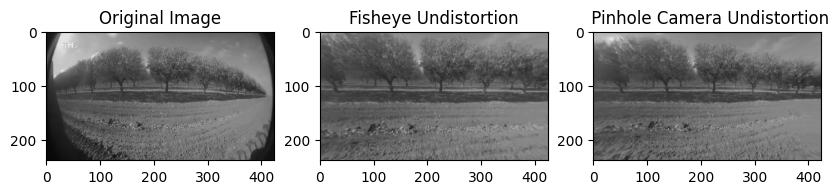

In [ ]:

DIM=_img_shape[::-1]
img = cv2.imread('2023-12-08 11-14-04.mkv100280.jpg')
h,w = img.shape[:2]

fisheye_undistorted_img = cv2.fisheye.undistortImage(img, K, D, None, K)


undistorted_img_dist = cv2.undistort(img, mtx, dist, None, newCameraMatrix=mtx)

# Display the images using matplotlib
plt.figure(figsize=(10, 8))
plt.subplot(131), plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(132), plt.imshow(cv.cvtColor(fisheye_undistorted_img, cv.COLOR_BGR2RGB)), plt.title('Fisheye Undistortion')
plt.subplot(133), plt.imshow(cv.cvtColor(undistorted_img_dist, cv.COLOR_BGR2RGB)), plt.title(' Pinhole Camera Undistortion')
plt.show()
